In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

# import pytorch_lightning as pl
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchmetrics as TM
# pl.utilities.seed.seed_everything(seed=42)
import numpy as np
import pandas as pd

import sys, os
source_path = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(source_path)
source_path = os.path.join(os.getcwd(), os.pardir, 'preprocessing')
sys.path.append(source_path)
source_path = os.path.join(os.getcwd(), os.pardir, 'metrics')
sys.path.append(source_path)
import matplotlib.pyplot as plt

from dl import NeuralNetwork, Trainer
from preprocess import (
    show_df, 
    date_features, 
    preprocess, 
    ToTorch, 
    get_loader, 
    ts_split,
    cont_cat_split,
    dataloader_by_stock,
    get_train_data
)
from metrics import calc_spread_return_sharpe
print(torch.__version__)

C:\Users\gilbe\anaconda3\envs\tokyo\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.11.0


In [2]:
print(torch.version.cuda), torch.cuda.is_available(), torch.cuda.device_count()

11.3


(None, True, 1)

##  Get Data and train a Neural Network

# Get the unique security codes

In [3]:
train_df = get_train_data()
print('Unique adjustment factor:', train_df['AdjustmentFactor'].unique())
print(train_df['AdjustmentFactor'])
train_df.head()

Unique adjustment factor: [ 1.          0.5         5.          0.33333333  0.83333333  0.25
  0.90909091  0.1        10.          0.2         0.95238095  2.
  0.14285714  0.66666667  0.86956522  0.76923077  0.8         4.
 20.        ]
Date
2017-01-04    1.0
2017-01-04    1.0
2017-01-04    1.0
2017-01-04    1.0
2017-01-04    1.0
             ... 
2021-12-03    1.0
2021-12-03    1.0
2021-12-03    1.0
2021-12-03    1.0
2021-12-03    1.0
Name: AdjustmentFactor, Length: 2332531, dtype: float64


,RowId,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
Date,,,,,,,,,,,
2017-01-04,20170104_1301,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
2017-01-04,20170104_1332,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2017-01-04,20170104_1333,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
2017-01-04,20170104_1376,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
2017-01-04,20170104_1377,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


# Create model

### Args and constants

In [4]:
CONT_COLS=['Close', 'Open', 'High', 'Low']
TS_IN_FEATURES = len(CONT_COLS)
CAT_FEATURES = 4 #cat.shape[1]
print('CAT_FEATURES:', CAT_FEATURES)
EMBEDDING_DIM = 300
NO_EMBEDDING = 2000 #2 * len(df_train_cat)

CAT_FEATURES: 4


In [5]:


model = NeuralNetwork(
    in_features=TS_IN_FEATURES, 
    units=1024,
    out_features=1, 
    categorical_dim=CAT_FEATURES,
    no_embedding=NO_EMBEDDING, 
    emb_dim=EMBEDDING_DIM,
    n_blocks=4,
    n_stacks=2,
    dropout=0.1
)

print(model)

NeuralNetwork(
  (embedding_layer): Embedding(2000, 300)
  (embedding_to_hidden): Linear(in_features=300, out_features=1024, bias=True)
  (embedding_output): Linear(in_features=1024, out_features=1, bias=True)
  (cont_input): Linear(in_features=4, out_features=1024, bias=True)
  (output_layer): Linear(in_features=1028, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (stacks): ModuleList(
    (0): NeuralStack(
      (stacks): ModuleList(
        (0): NeuralBlock(
          (dropout): Dropout(p=0.1, inplace=False)
          (layer1): Linear(in_features=1028, out_features=1028, bias=True)
          (layer2): Linear(in_features=1028, out_features=1028, bias=True)
          (layer3): Linear(in_features=1028, out_features=1028, bias=True)
          (layer4): Linear(in_features=1028, out_features=1028, bias=True)
          (output): Linear(in_features=1028, out_features=1028, bias=True)
          (res_output): Linear(in_features=1028, out_features=1028, bias=True)
    

# Loop throug each stock
Create Trainer only once

Using cuda-device
Start training for stock: 1301


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>


C:\Users\gilbe\anaconda3\envs\tokyo\lib\site-packages\torch\autograd\__init__.py:173: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Copy.cpp:239.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Train metrics: {'mse': 0.39689144492149353, 'mae': 0.6053162813186646}
Validation metrics: {'mse': 0.00836587231606245, 'mae': 0.07385681569576263}
Average train loss: 0.014833594858646392 | Average val loss: 0.00836587231606245
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.017979798838496208, 'mae': 0.09533822536468506}
Validation metrics: {'mse': 0.007802032399922609, 'mae': 0.0666155219078064}
Average train loss: 0.0012676876038312912 | Average val loss: 0.007802032865583897
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.016470294445753098, 'mae': 0.093538299202919}
Validation metrics: {'mse': 0.007246265187859535, 'mae': 0.0644320547580719}
Average train loss: 0.000936165452003479 | Average val loss: 0.0072462656535208225
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.014056655578315258, 'mae': 0.08295602351427078}
Validation m

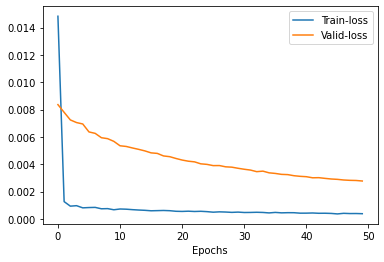

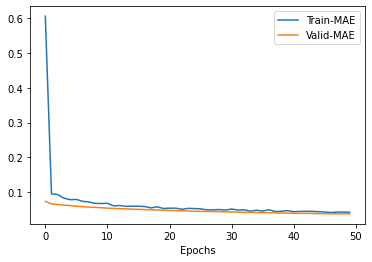

####################

Start training for stock: 1332
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Train metrics: {'mse': 0.010029653087258339, 'mae': 0.08389056473970413}
Validation metrics: {'mse': 0.005863639526069164, 'mae': 0.06235106661915779}
Average train loss: 0.00039475751109421255 | Average val loss: 0.005863639526069164
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.008365310728549957, 'mae': 0.07399109750986099}
Validation metrics: {'mse': 0.005511173978447914, 'mae': 0.06092388182878494}
Average train loss: 0.0003817438147962093 | Average val loss: 0.005511173978447914
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.007936875335872173, 'mae': 0.07234258949756622}
Validation metrics: {'mse': 0.005479666870087385, 'mae': 0.06097423657774925}
Average train loss: 0.0003810374531894922 | Average val loss: 0.005479666870087385
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.007545533590018749, 'mae': 0.06986553966999054}
Va

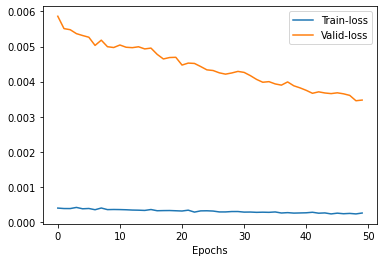

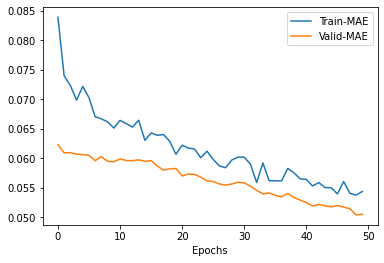

####################

Start training for stock: 1333
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Train metrics: {'mse': 0.003052813932299614, 'mae': 0.04338287562131882}
Validation metrics: {'mse': 0.0011110063642263412, 'mae': 0.026239098981022835}
Average train loss: 0.00019153065513819457 | Average val loss: 0.0011110063642263412
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.002852918580174446, 'mae': 0.04163016378879547}
Validation metrics: {'mse': 0.0010818707523867488, 'mae': 0.02575276419520378}
Average train loss: 0.00019370615482330322 | Average val loss: 0.0010818708688020706
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.0029496196657419205, 'mae': 0.04240306839346886}
Validation metrics: {'mse': 0.001067710341885686, 'mae': 0.025605710223317146}
Average train loss: 0.00018236911855638028 | Average val loss: 0.001067710341885686
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.0031075680162757635, 'mae': 0.04297744855

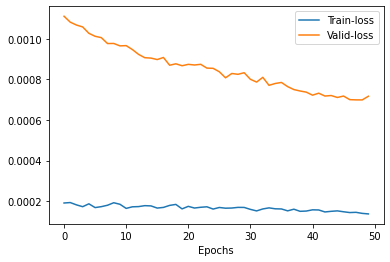

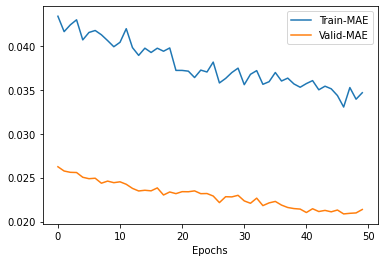

####################

Start training for stock: 1376
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Train metrics: {'mse': 0.0033051790669560432, 'mae': 0.044495560228824615}
Validation metrics: {'mse': 0.0026366631500422955, 'mae': 0.043097689747810364}
Average train loss: 0.0001642195740714669 | Average val loss: 0.0026366631500422955
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.002949822461232543, 'mae': 0.04311303049325943}
Validation metrics: {'mse': 0.0026973546482622623, 'mae': 0.043715424835681915}
Average train loss: 0.00016527555417269468 | Average val loss: 0.0026973546482622623
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.002864220179617405, 'mae': 0.042342618107795715}
Validation metrics: {'mse': 0.0027698141057044268, 'mae': 0.04439222067594528}
Average train loss: 0.00017009361181408167 | Average val loss: 0.0027698141057044268
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.0028860250022262335, 'mae': 0.04231458

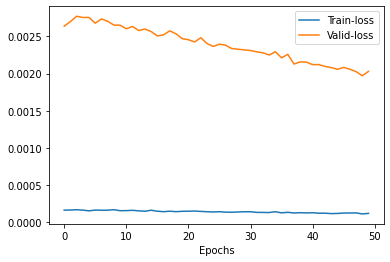

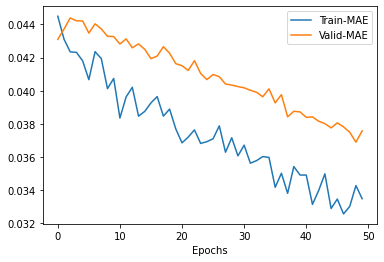

####################

Start training for stock: 1377
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Train metrics: {'mse': 0.002211512066423893, 'mae': 0.03779909759759903}
Validation metrics: {'mse': 0.0022975318133831024, 'mae': 0.039868488907814026}
Average train loss: 0.00011976480018347502 | Average val loss: 0.0022975318133831024
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.002221034374088049, 'mae': 0.037462446838617325}
Validation metrics: {'mse': 0.0022197477519512177, 'mae': 0.0392809621989727}
Average train loss: 0.00011154103558510541 | Average val loss: 0.0022197477519512177
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.0021757634822279215, 'mae': 0.03662748262286186}
Validation metrics: {'mse': 0.0021713031455874443, 'mae': 0.038902949541807175}
Average train loss: 0.0001134718069806695 | Average val loss: 0.002171303378418088
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.0022143961396068335, 'mae': 0.03701697289

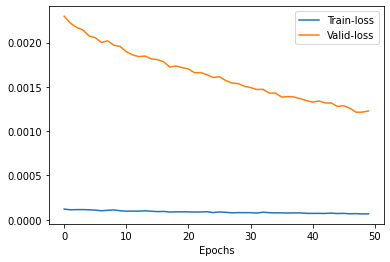

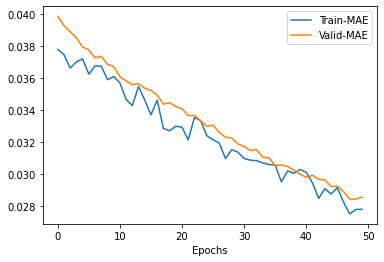

####################

Start training for stock: 1379
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Train metrics: {'mse': 0.0010031629353761673, 'mae': 0.025427144020795822}
Validation metrics: {'mse': 0.001548404456116259, 'mae': 0.03004741668701172}
Average train loss: 7.66244949772954e-05 | Average val loss: 0.001548404572531581
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.0010418205056339502, 'mae': 0.02548203244805336}
Validation metrics: {'mse': 0.0014266775688156486, 'mae': 0.02887815423309803}
Average train loss: 8.038348751142621e-05 | Average val loss: 0.0014266776852309704
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.001082765869796276, 'mae': 0.026081619784235954}
Validation metrics: {'mse': 0.0015039535937830806, 'mae': 0.029483115300536156}
Average train loss: 7.711038342677057e-05 | Average val loss: 0.0015039535937830806
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.0009994609281420708, 'mae': 0.0252323672175

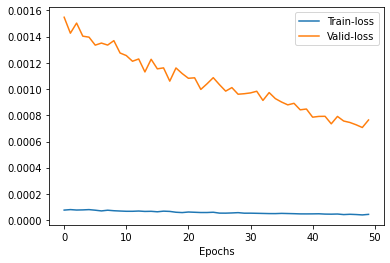

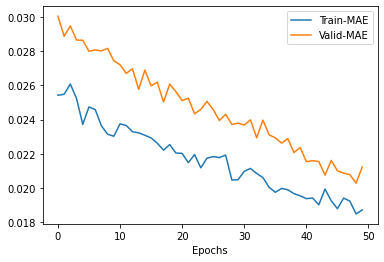

####################

Start training for stock: 1381
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Train metrics: {'mse': 0.0006250474252738059, 'mae': 0.015498608350753784}
Validation metrics: {'mse': 0.0014431846793740988, 'mae': 0.034914467483758926}
Average train loss: 5.834647454321385e-05 | Average val loss: 0.0014431847957894206
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.0006013251841068268, 'mae': 0.015426330268383026}
Validation metrics: {'mse': 0.0010159319499507546, 'mae': 0.0283272173255682}
Average train loss: 6.166674429550767e-05 | Average val loss: 0.0010159319499507546
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.0006054847617633641, 'mae': 0.015637673437595367}
Validation metrics: {'mse': 0.0014819027855992317, 'mae': 0.035445284098386765}
Average train loss: 6.23539264779538e-05 | Average val loss: 0.0014819027855992317
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.0005998042761348188, 'mae': 0.015885930

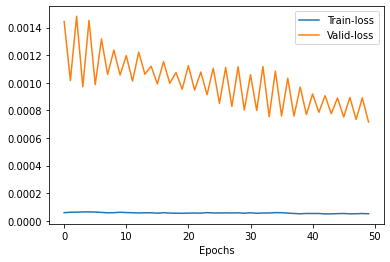

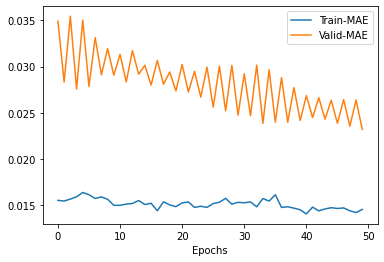

####################

Start training for stock: 1407
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Train metrics: {'mse': 0.0016123084351420403, 'mae': 0.03052922524511814}
Validation metrics: {'mse': 0.002086450345814228, 'mae': 0.03628825023770332}
Average train loss: 3.486630157567561e-05 | Average val loss: 0.002086450345814228
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.0017385411774739623, 'mae': 0.03299935907125473}
Validation metrics: {'mse': 0.06913153827190399, 'mae': 0.23975621163845062}
Average train loss: 3.5239561111666265e-05 | Average val loss: 0.06913153827190399
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.002268824027851224, 'mae': 0.03608788922429085}
Validation metrics: {'mse': 0.009200110100209713, 'mae': 0.08759000152349472}
Average train loss: 3.819292178377509e-05 | Average val loss: 0.009200111031532288
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.0022865133360028267, 'mae': 0.0386449359357357}
Va

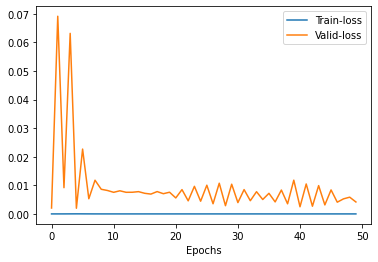

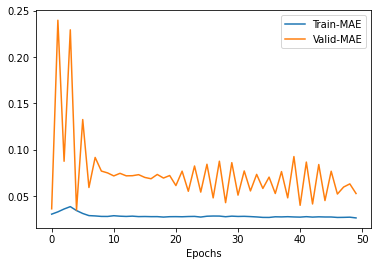

####################

Start training for stock: 1414
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Train metrics: {'mse': 0.00033284362871199846, 'mae': 0.01382487267255783}
Validation metrics: {'mse': 0.00018063814786728472, 'mae': 0.010348153300583363}
Average train loss: 1.8957193242385982e-05 | Average val loss: 0.00018063814786728472
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.0003704190021380782, 'mae': 0.014442327432334423}
Validation metrics: {'mse': 0.00019226575386710465, 'mae': 0.01075339037925005}
Average train loss: 1.9464758224785328e-05 | Average val loss: 0.00019226576841901988
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.00034834735561162233, 'mae': 0.014086383394896984}
Validation metrics: {'mse': 0.00017516505613457412, 'mae': 0.01019600685685873}
Average train loss: 1.9579465151764454e-05 | Average val loss: 0.00017516505613457412
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.00037703284760937095, 'mae':

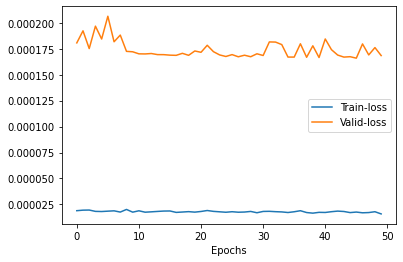

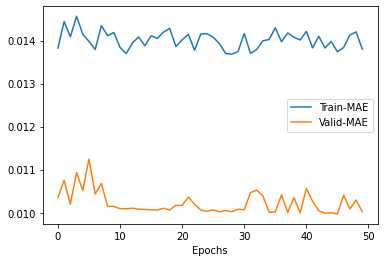

####################

Start training for stock: 1417
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Train metrics: {'mse': 0.0004636045196093619, 'mae': 0.016304263845086098}
Validation metrics: {'mse': 0.0009311845060437918, 'mae': 0.024452093988656998}
Average train loss: 1.9724952289834617e-05 | Average val loss: 0.0009311845060437918
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.00047098149661906064, 'mae': 0.01625721901655197}
Validation metrics: {'mse': 0.0008016187348403037, 'mae': 0.02266881614923477}
Average train loss: 1.9795793923549355e-05 | Average val loss: 0.0008016187930479646
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.00046565523371100426, 'mae': 0.016314148902893066}
Validation metrics: {'mse': 0.0009130178950726986, 'mae': 0.024222513660788536}
Average train loss: 1.9641329708974807e-05 | Average val loss: 0.0009130178950726986
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.0004627452581189573, 'mae': 0.016

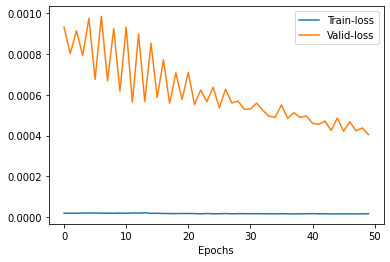

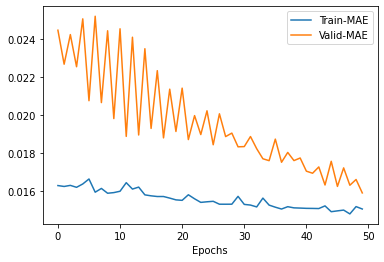

####################

Start training for stock: 1419
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Train metrics: {'mse': 0.0008470343891531229, 'mae': 0.02150668017566204}
Validation metrics: {'mse': 0.001530668349005282, 'mae': 0.03003968484699726}
Average train loss: 3.43161285854876e-05 | Average val loss: 0.001530668349005282
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.0008957416866905987, 'mae': 0.022344576194882393}
Validation metrics: {'mse': 0.004871900659054518, 'mae': 0.05860203504562378}
Average train loss: 3.543564816936851e-05 | Average val loss: 0.004871901124715805
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.0009599272161722183, 'mae': 0.023229647427797318}
Validation metrics: {'mse': 0.0034958848264068365, 'mae': 0.051337115466594696}
Average train loss: 3.531856345944107e-05 | Average val loss: 0.0034958848264068365
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.0009398037218488753, 'mae': 0.02318204194307

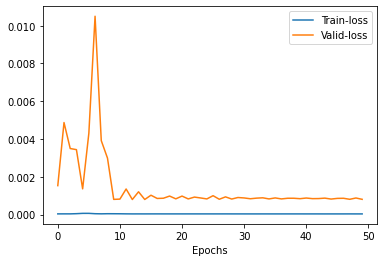

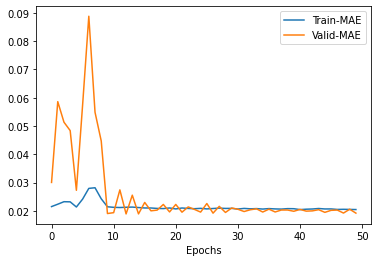

####################

Start training for stock: 1429
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Train metrics: {'mse': 0.0009619556367397308, 'mae': 0.022281862795352936}
Validation metrics: {'mse': 0.0004592704644892365, 'mae': 0.01601516269147396}
Average train loss: 3.112773993052542e-05 | Average val loss: 0.00045927049359306693
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.0009601640049368143, 'mae': 0.02193772979080677}
Validation metrics: {'mse': 0.0004367563233245164, 'mae': 0.015309450216591358}
Average train loss: 3.35592107148841e-05 | Average val loss: 0.0004367563233245164
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.0009458817658014596, 'mae': 0.022108545526862144}
Validation metrics: {'mse': 0.00042962809675373137, 'mae': 0.015062891878187656}
Average train loss: 3.243472310714424e-05 | Average val loss: 0.00042962809675373137
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.0010068417759612203, 'mae': 0.022641

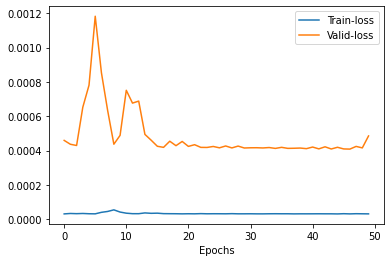

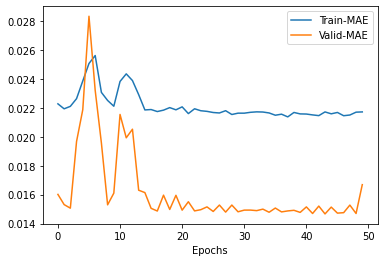

####################

Start training for stock: 1435
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Train metrics: {'mse': 0.0017785755917429924, 'mae': 0.027533793821930885}
Validation metrics: {'mse': 0.0011855122866109014, 'mae': 0.022828981280326843}
Average train loss: 0.00011944947764277458 | Average val loss: 0.0011855124030262232
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.001707209856249392, 'mae': 0.027126919478178024}
Validation metrics: {'mse': 0.0011691628023982048, 'mae': 0.022143065929412842}
Average train loss: 0.00012218175688758493 | Average val loss: 0.0011691628023982048
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.0017661969177424908, 'mae': 0.02744460664689541}
Validation metrics: {'mse': 0.0011916267685592175, 'mae': 0.02300579473376274}
Average train loss: 0.000121312087867409 | Average val loss: 0.0011916267685592175
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.0017462652176618576, 'mae': 0.02784802

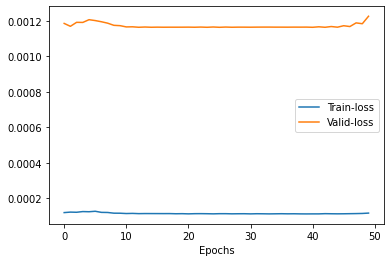

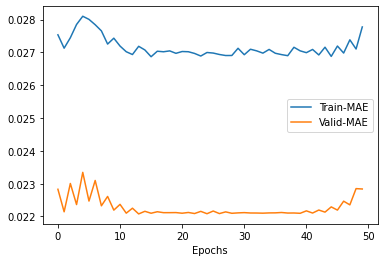

####################

Start training for stock: 1515
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Train metrics: {'mse': 0.0005083958967588842, 'mae': 0.017047347500920296}
Validation metrics: {'mse': 0.0009216697071678936, 'mae': 0.023456567898392677}
Average train loss: 3.739009844139218e-05 | Average val loss: 0.0009216697071678936
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.0006062255124561489, 'mae': 0.019035985693335533}
Validation metrics: {'mse': 0.0007608669111505151, 'mae': 0.021463502198457718}
Average train loss: 3.714419435709715e-05 | Average val loss: 0.0007608669111505151
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.0006074915872886777, 'mae': 0.018900694325566292}
Validation metrics: {'mse': 0.0007320588920265436, 'mae': 0.020542312413454056}
Average train loss: 3.991489938925952e-05 | Average val loss: 0.0007320588920265436
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.0007291843648999929, 'mae': 0.021251

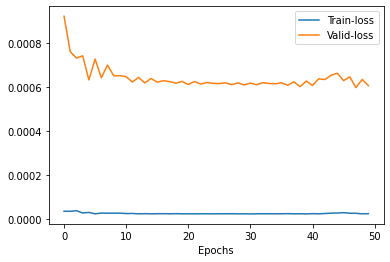

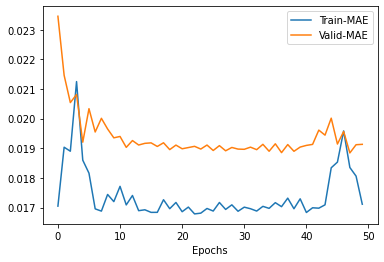

####################

Start training for stock: 1518
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Train metrics: {'mse': 0.0006038025603629649, 'mae': 0.01815425045788288}
Validation metrics: {'mse': 0.002206080825999379, 'mae': 0.04006125032901764}
Average train loss: 2.3470146697945892e-05 | Average val loss: 0.002206080825999379
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.0008403743267990649, 'mae': 0.02174140326678753}
Validation metrics: {'mse': 0.0020142148714512587, 'mae': 0.037129394710063934}
Average train loss: 2.532468060962856e-05 | Average val loss: 0.0020142148714512587
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.0009434517123736441, 'mae': 0.022921137511730194}
Validation metrics: {'mse': 0.0021266492549329996, 'mae': 0.03918790817260742}
Average train loss: 2.827742719091475e-05 | Average val loss: 0.0021266492549329996
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.0007419376051984727, 'mae': 0.02030130103

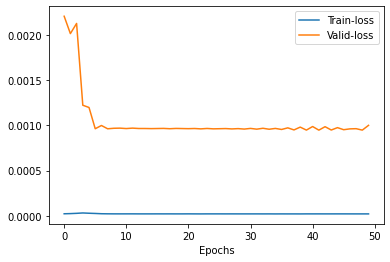

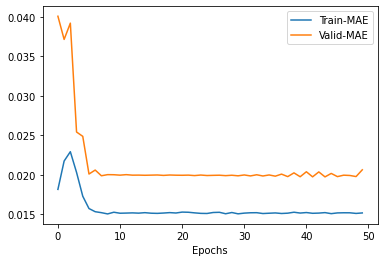

####################

Start training for stock: 1605
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Train metrics: {'mse': 0.0007121730013750494, 'mae': 0.019319385290145874}
Validation metrics: {'mse': 0.0006231213337741792, 'mae': 0.01964859664440155}
Average train loss: 1.6654662613291293e-05 | Average val loss: 0.0006231213919818401
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.0007241290295496583, 'mae': 0.01982443779706955}
Validation metrics: {'mse': 0.0008064339635893703, 'mae': 0.022564535960555077}
Average train loss: 1.670425699558109e-05 | Average val loss: 0.0008064339635893703
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.0007498841732740402, 'mae': 0.019841598346829414}
Validation metrics: {'mse': 0.0007361202733591199, 'mae': 0.021642887964844704}
Average train loss: 1.696539839031175e-05 | Average val loss: 0.0007361203315667808
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.0007453702273778617, 'mae': 0.0201446

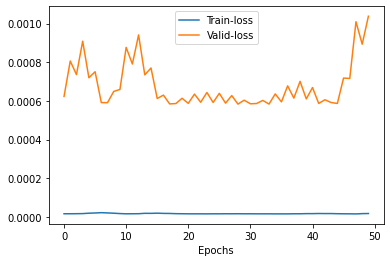

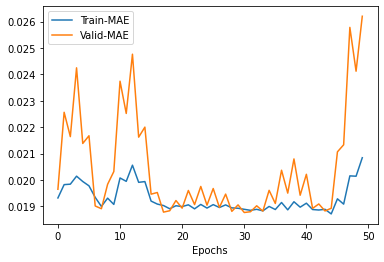

####################

Start training for stock: 1662
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Train metrics: {'mse': 0.0006762802950106561, 'mae': 0.019272081553936005}
Validation metrics: {'mse': 0.0005243500345386565, 'mae': 0.017207331955432892}
Average train loss: 2.9537687078118323e-05 | Average val loss: 0.0005243500345386565
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.000655380601529032, 'mae': 0.018743855878710747}
Validation metrics: {'mse': 0.0005675818538293242, 'mae': 0.018029654398560524}
Average train loss: 2.2905277728568762e-05 | Average val loss: 0.0005675818538293242
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.0006435013492591679, 'mae': 0.018571296706795692}
Validation metrics: {'mse': 0.0005409079603850842, 'mae': 0.01747412420809269}
Average train loss: 2.3321113258134573e-05 | Average val loss: 0.0005409080185927451
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.0006489193183369935, 'mae': 0.01859

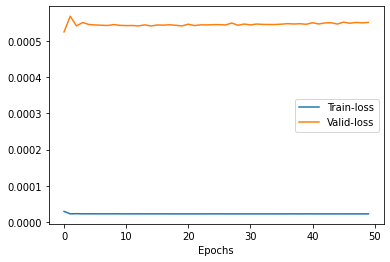

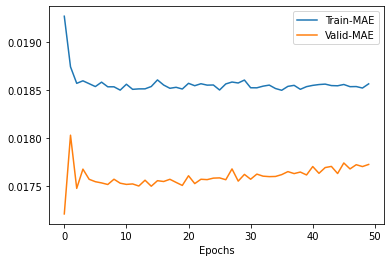

####################

Start training for stock: 1663
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Train metrics: {'mse': 0.0006348017486743629, 'mae': 0.018880784511566162}
Validation metrics: {'mse': 0.0002769350539892912, 'mae': 0.012663406319916248}
Average train loss: 1.2014475942123681e-05 | Average val loss: 0.0002769350539892912
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.0006185461534187198, 'mae': 0.018674153834581375}
Validation metrics: {'mse': 0.00023186930047813803, 'mae': 0.010715791955590248}
Average train loss: 1.2470365618355572e-05 | Average val loss: 0.00023186930047813803
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.0006455776165239513, 'mae': 0.01929830200970173}
Validation metrics: {'mse': 0.0002719600743148476, 'mae': 0.011944619007408619}
Average train loss: 1.5471714141312988e-05 | Average val loss: 0.0002719600743148476
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.0006582899368368089, 'mae': 0.01

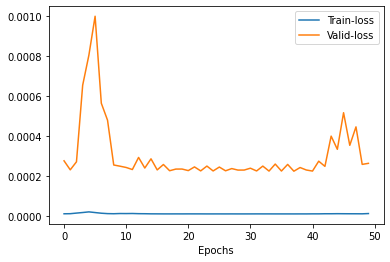

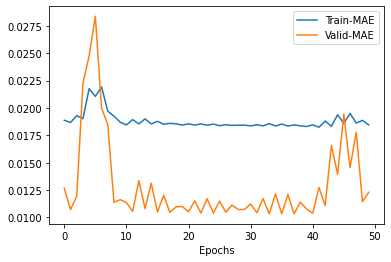

####################

Start training for stock: 1712
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Train metrics: {'mse': 0.000782827555667609, 'mae': 0.0186802726238966}
Validation metrics: {'mse': 0.0009486834169365466, 'mae': 0.02179752103984356}
Average train loss: 2.87787988781929e-05 | Average val loss: 0.0009486834169365466
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.0008045985014177859, 'mae': 0.019873518496751785}
Validation metrics: {'mse': 0.0008124349405989051, 'mae': 0.020910222083330154}
Average train loss: 3.1575007596984506e-05 | Average val loss: 0.000812434998806566
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.0008243893971666694, 'mae': 0.019327061250805855}
Validation metrics: {'mse': 0.0009683637763373554, 'mae': 0.022557955235242844}
Average train loss: 3.196940233465284e-05 | Average val loss: 0.0009683637763373554
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.0008260113536380231, 'mae': 0.02085828967

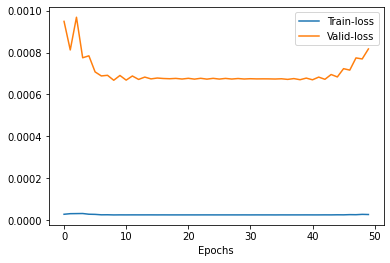

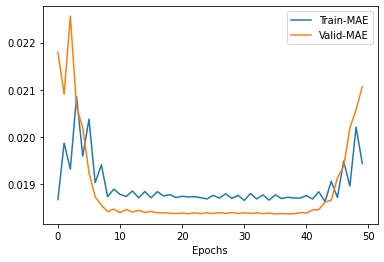

####################

Start training for stock: 1716
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Train metrics: {'mse': 0.0005718747852370143, 'mae': 0.017106706276535988}
Validation metrics: {'mse': 0.0005764352390542626, 'mae': 0.01765567995607853}
Average train loss: 3.938540467061102e-05 | Average val loss: 0.0005764352390542626
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.000582501117605716, 'mae': 0.01760617457330227}
Validation metrics: {'mse': 0.0004412732960190624, 'mae': 0.015280631370842457}
Average train loss: 3.6755402106791735e-05 | Average val loss: 0.00044127332512289286
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.000561390770599246, 'mae': 0.016949569806456566}
Validation metrics: {'mse': 0.00047712703235447407, 'mae': 0.015475589781999588}
Average train loss: 3.341028350405395e-05 | Average val loss: 0.0004771270614583045
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.0005637843278236687, 'mae': 0.0171396

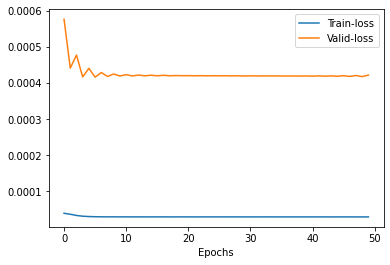

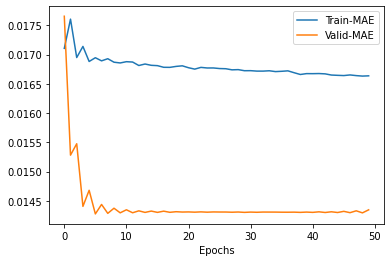

####################

Start training for stock: 1719
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Train metrics: {'mse': 0.00037529339897446334, 'mae': 0.01472241710871458}
Validation metrics: {'mse': 0.00041750812670215964, 'mae': 0.01310511864721775}
Average train loss: 1.9208542653359473e-05 | Average val loss: 0.0004175081558059901
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.0003791909257415682, 'mae': 0.014855166897177696}
Validation metrics: {'mse': 0.00041513796895742416, 'mae': 0.013095051981508732}
Average train loss: 1.9548565614968538e-05 | Average val loss: 0.00041513796895742416
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.000389474822441116, 'mae': 0.015118923969566822}
Validation metrics: {'mse': 0.00042105719330720603, 'mae': 0.013211598619818687}
Average train loss: 1.9653327763080596e-05 | Average val loss: 0.00042105719330720603
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.0003995997249148786, 'mae': 0.

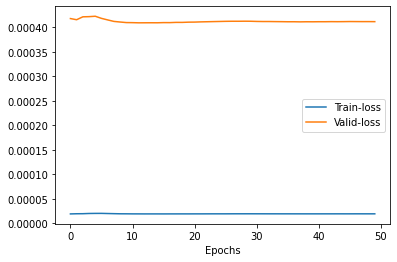

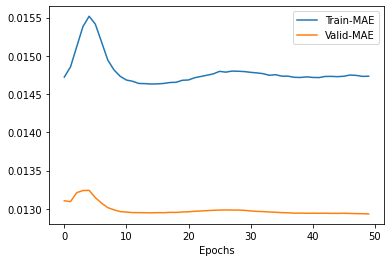

####################

Start training for stock: 1720
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Train metrics: {'mse': 0.0004403353377711028, 'mae': 0.014991194009780884}
Validation metrics: {'mse': 0.0004208610043860972, 'mae': 0.013418559916317463}
Average train loss: 1.5260788495652376e-05 | Average val loss: 0.0004208610043860972
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.00044180097756907344, 'mae': 0.015146310441195965}
Validation metrics: {'mse': 0.0005182545282877982, 'mae': 0.016331205144524574}
Average train loss: 1.5586773224640636e-05 | Average val loss: 0.0005182545282877982
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.0006201430223882198, 'mae': 0.018662210553884506}
Validation metrics: {'mse': 0.0025361732114106417, 'mae': 0.04295860230922699}
Average train loss: 1.677680411376059e-05 | Average val loss: 0.0025361732114106417
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.0015912546077743173, 'mae': 0.0319

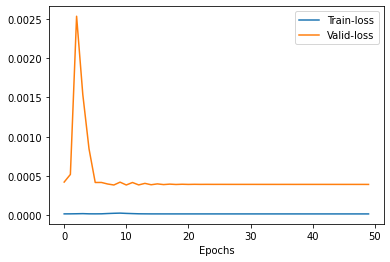

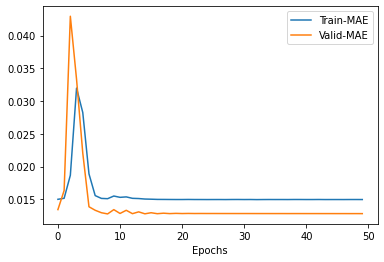

####################

Start training for stock: 1721
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Train metrics: {'mse': 0.00029731617541983724, 'mae': 0.012189474888145924}
Validation metrics: {'mse': 0.00023766560479998589, 'mae': 0.011792262084782124}
Average train loss: 1.1792073928518221e-05 | Average val loss: 0.00023766560479998589
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.00030340117518790066, 'mae': 0.012289307080209255}
Validation metrics: {'mse': 0.00023467434220947325, 'mae': 0.011662066914141178}
Average train loss: 1.1964073200942948e-05 | Average val loss: 0.00023467434220947325
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.00029846790130250156, 'mae': 0.012202049605548382}
Validation metrics: {'mse': 0.00023651920491829515, 'mae': 0.011754595674574375}
Average train loss: 1.1556151730474084e-05 | Average val loss: 0.00023651920491829515
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.0003005055186804384, 'ma

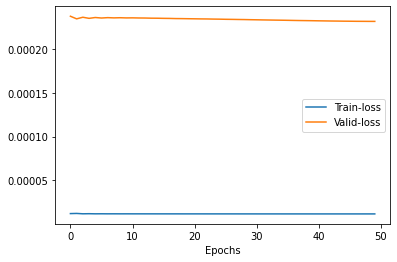

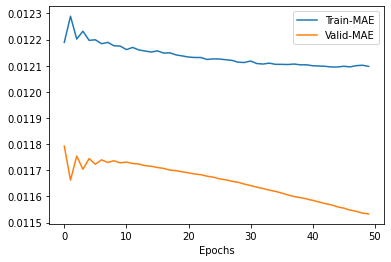

####################

Start training for stock: 1723
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Train metrics: {'mse': 0.0003952670667786151, 'mae': 0.014386325143277645}
Validation metrics: {'mse': 0.005482337437570095, 'mae': 0.07285977154970169}
Average train loss: 1.1685988283716142e-05 | Average val loss: 0.005482337437570095
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.0008412058814428747, 'mae': 0.02151324972510338}
Validation metrics: {'mse': 0.012162772938609123, 'mae': 0.10858777165412903}
Average train loss: 1.333187537966296e-05 | Average val loss: 0.012162772938609123
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.001635750406421721, 'mae': 0.028851643204689026}
Validation metrics: {'mse': 0.0040482040494680405, 'mae': 0.06245573237538338}
Average train loss: 1.5994446584954858e-05 | Average val loss: 0.0040482040494680405
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.0007950134458951652, 'mae': 0.0210602879524

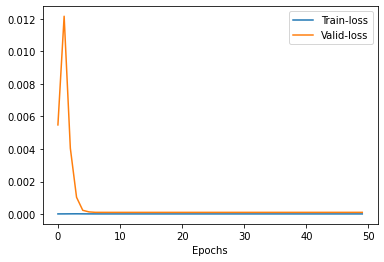

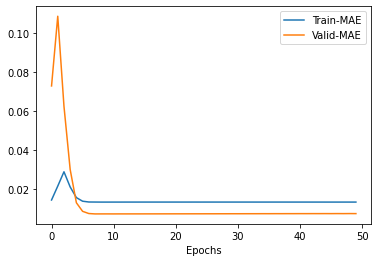

####################

Start training for stock: 1726
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Train metrics: {'mse': 0.00058236118638888, 'mae': 0.017678778618574142}
Validation metrics: {'mse': 0.00045208996743895113, 'mae': 0.016569392755627632}
Average train loss: 2.6574882213026285e-05 | Average val loss: 0.00045208996743895113
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.0005810388829559088, 'mae': 0.01775975711643696}
Validation metrics: {'mse': 0.0004029739066027105, 'mae': 0.015517126768827438}
Average train loss: 2.6892428286373617e-05 | Average val loss: 0.00040297393570654094
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.0005828388966619968, 'mae': 0.017771603539586067}
Validation metrics: {'mse': 0.00044357383740134537, 'mae': 0.016422167420387268}
Average train loss: 2.687256783246994e-05 | Average val loss: 0.00044357386650517583
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.0005798169877380133, 'mae': 0.01

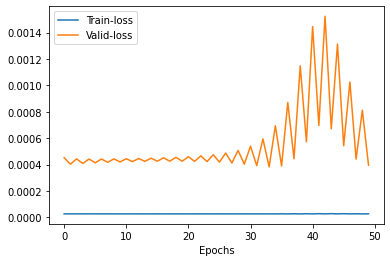

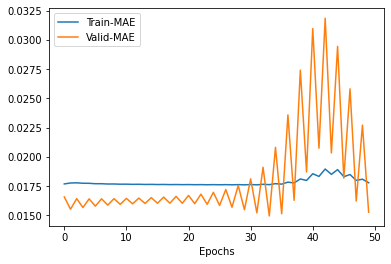

####################

Start training for stock: 1762
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Train metrics: {'mse': 0.0004116228665225208, 'mae': 0.014942428097128868}
Validation metrics: {'mse': 0.00017306052905041724, 'mae': 0.01062597706913948}
Average train loss: 1.2463776511140167e-05 | Average val loss: 0.00017306054360233247
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.0004148881998844445, 'mae': 0.015017311088740826}
Validation metrics: {'mse': 0.00047099738731049, 'mae': 0.01885412074625492}
Average train loss: 1.2297366629354655e-05 | Average val loss: 0.00047099741641432047
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.00048617227002978325, 'mae': 0.0165031086653471}
Validation metrics: {'mse': 0.0021932630334049463, 'mae': 0.044825635850429535}
Average train loss: 1.2009701458737254e-05 | Average val loss: 0.0021932630334049463
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.0008294323342852294, 'mae': 0.02234

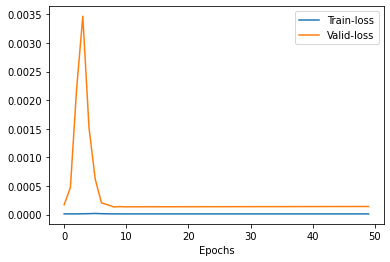

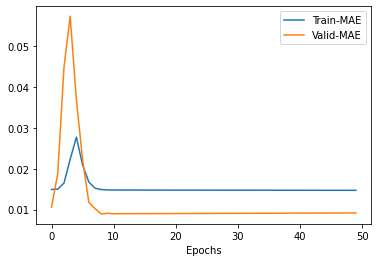

####################

Start training for stock: 1766
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Train metrics: {'mse': 0.00030420481925830245, 'mae': 0.0121708819642663}
Validation metrics: {'mse': 0.0002216497523477301, 'mae': 0.011270224116742611}
Average train loss: 1.861235941760242e-05 | Average val loss: 0.00022164976689964533
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.0003011426015291363, 'mae': 0.012081393972039223}
Validation metrics: {'mse': 0.00022739234555047005, 'mae': 0.011260238476097584}
Average train loss: 1.8867090693674983e-05 | Average val loss: 0.00022739234555047005
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.000302552041830495, 'mae': 0.012069204822182655}
Validation metrics: {'mse': 0.00022948170953895897, 'mae': 0.011594189330935478}
Average train loss: 1.9755236280616373e-05 | Average val loss: 0.00022948170953895897
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.0003071505343541503, 'mae': 0.0

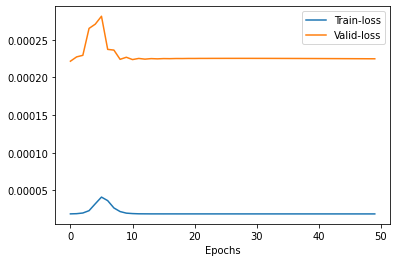

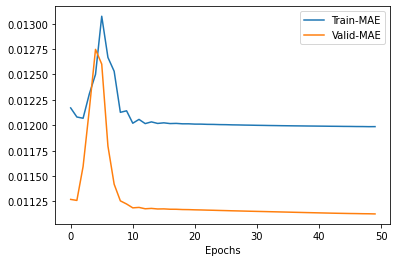

####################

Start training for stock: 1775
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Train metrics: {'mse': 0.0002489224716555327, 'mae': 0.00921698845922947}
Validation metrics: {'mse': 0.00019196035282220691, 'mae': 0.009818091057240963}
Average train loss: 8.623156463727356e-06 | Average val loss: 0.00019196036737412214
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.00025008677039295435, 'mae': 0.00946186762303114}
Validation metrics: {'mse': 0.0002071954368147999, 'mae': 0.0103685287758708}
Average train loss: 8.950604387791827e-06 | Average val loss: 0.0002071954368147999
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.00025659985840320587, 'mae': 0.009749348275363445}
Validation metrics: {'mse': 0.0002186710189562291, 'mae': 0.010833187028765678}
Average train loss: 9.549864626023918e-06 | Average val loss: 0.0002186710189562291
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.00026708104996941984, 'mae': 0.01048

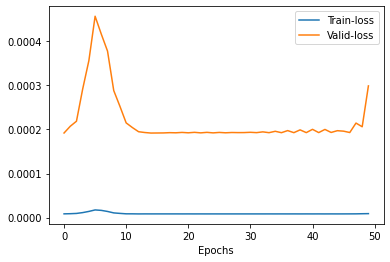

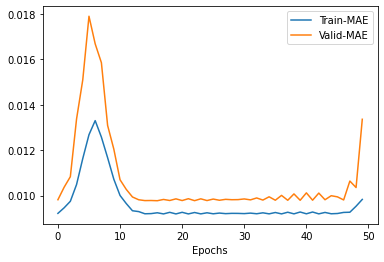

####################

Start training for stock: 1780
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Train metrics: {'mse': 0.00026211777003481984, 'mae': 0.011065548285841942}
Validation metrics: {'mse': 9.848628542385995e-05, 'mae': 0.007176961284130812}
Average train loss: 1.0655383812263608e-05 | Average val loss: 9.848628542385995e-05
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.00030055211391299963, 'mae': 0.012079883366823196}
Validation metrics: {'mse': 9.355734073324129e-05, 'mae': 0.0069089410826563835}
Average train loss: 1.116065395763144e-05 | Average val loss: 9.355734073324129e-05
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.00024434007355012, 'mae': 0.010336953215301037}
Validation metrics: {'mse': 9.17396682780236e-05, 'mae': 0.0069151767529547215}
Average train loss: 9.413473162567242e-06 | Average val loss: 9.17396682780236e-05
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.00025599784567020833, 'mae': 0.0106

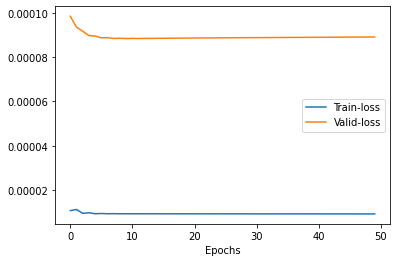

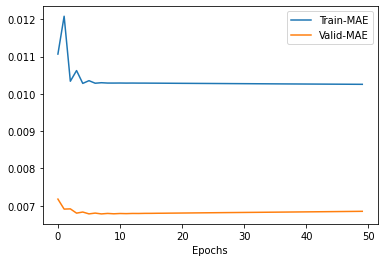

####################

Start training for stock: 1787
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Train metrics: {'mse': 0.00015802186680957675, 'mae': 0.006557215005159378}
Validation metrics: {'mse': 0.000876481703016907, 'mae': 0.022067002952098846}
Average train loss: 1.7930235480889677e-05 | Average val loss: 0.0008764817612245679
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.00015581150364596397, 'mae': 0.006517508532851934}
Validation metrics: {'mse': 0.0007819413440302014, 'mae': 0.01890149898827076}
Average train loss: 1.844891521614045e-05 | Average val loss: 0.0007819413440302014
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.00015574894496239722, 'mae': 0.006483377888798714}
Validation metrics: {'mse': 0.0007825926877558231, 'mae': 0.019135858863592148}
Average train loss: 1.7962351557798682e-05 | Average val loss: 0.0007825926877558231
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.0001554135960759595, 'mae': 0.006

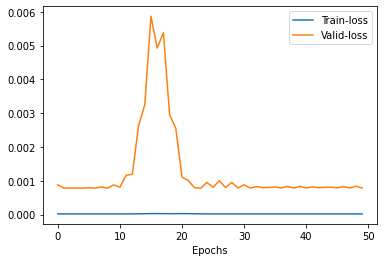

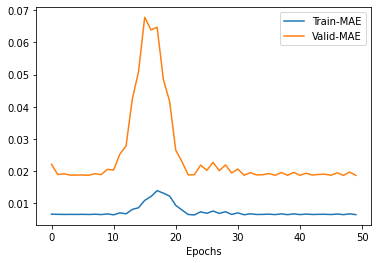

####################

Start training for stock: 1793
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Train metrics: {'mse': 0.00021439549163915217, 'mae': 0.009948785416781902}
Validation metrics: {'mse': 0.00014581382856704295, 'mae': 0.008726131170988083}
Average train loss: 1.0864306386793032e-05 | Average val loss: 0.00014581382856704295
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.00021540388115681708, 'mae': 0.009907728061079979}
Validation metrics: {'mse': 0.00014475558418780565, 'mae': 0.00863763876259327}
Average train loss: 1.1889739835169166e-05 | Average val loss: 0.00014475558418780565
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.0002228768280474469, 'mae': 0.010543668642640114}
Validation metrics: {'mse': 0.00014762089995201677, 'mae': 0.008853104896843433}
Average train loss: 1.874652225524187e-05 | Average val loss: 0.00014762088540010154
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.00023230703664012253, 'mae'

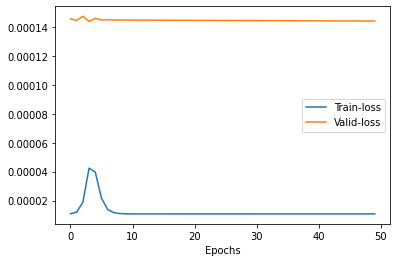

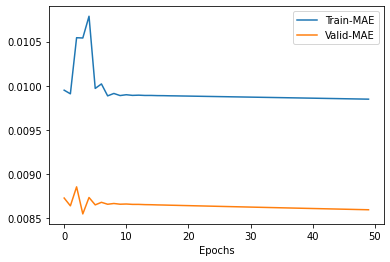

####################

Start training for stock: 1799
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Train metrics: {'mse': 9.47801090660505e-05, 'mae': 0.006696754135191441}
Validation metrics: {'mse': 0.0001401316694682464, 'mae': 0.008485338650643826}
Average train loss: 4.836177322431468e-06 | Average val loss: 0.0001401316694682464
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 9.470296936342493e-05, 'mae': 0.006689589936286211}
Validation metrics: {'mse': 0.0001379271416226402, 'mae': 0.008386289700865746}
Average train loss: 4.76108689326793e-06 | Average val loss: 0.0001379271416226402
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 9.480707376496866e-05, 'mae': 0.006702072452753782}
Validation metrics: {'mse': 0.0001423259818693623, 'mae': 0.008584178052842617}
Average train loss: 4.779898154083639e-06 | Average val loss: 0.0001423259818693623
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 9.47256776271388e-05, 'mae': 0.006690122

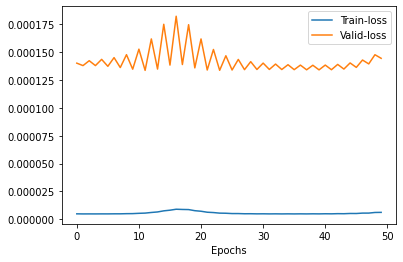

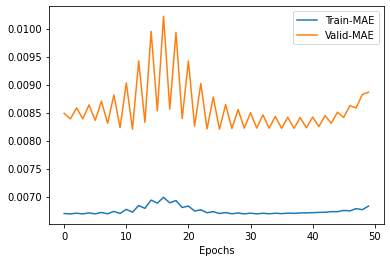

####################

Start training for stock: 1801
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Train metrics: {'mse': 0.00039803015533834696, 'mae': 0.014964459463953972}
Validation metrics: {'mse': 0.0002910626935772598, 'mae': 0.012682968750596046}
Average train loss: 1.5144569624681026e-05 | Average val loss: 0.0002910626935772598
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.00041997854714281857, 'mae': 0.015260743908584118}
Validation metrics: {'mse': 0.00031470294925384223, 'mae': 0.01328797172755003}
Average train loss: 1.535471237730235e-05 | Average val loss: 0.00031470294925384223
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.00039704280789010227, 'mae': 0.014913439750671387}
Validation metrics: {'mse': 0.00029354277648963034, 'mae': 0.012743493542075157}
Average train loss: 1.4174172247294336e-05 | Average val loss: 0.00029354277648963034
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.00041010748827829957, 'mae':

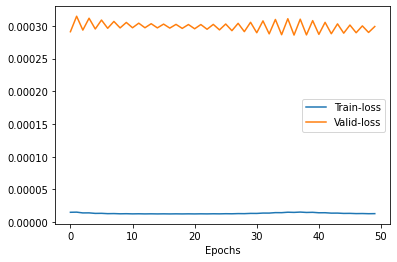

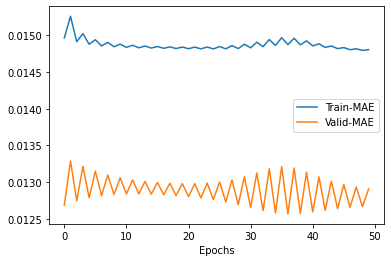

####################

Start training for stock: 1802
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Train metrics: {'mse': 0.00036871532211080194, 'mae': 0.013695073314011097}
Validation metrics: {'mse': 0.0003063600161112845, 'mae': 0.013467581942677498}
Average train loss: 1.2252686428837477e-05 | Average val loss: 0.00030636004521511495
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.00036601675674319267, 'mae': 0.01372426375746727}
Validation metrics: {'mse': 0.00029983281274326146, 'mae': 0.013226103037595749}
Average train loss: 1.2296093336772173e-05 | Average val loss: 0.0002998328418470919
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.0003616739995777607, 'mae': 0.013691205531358719}
Validation metrics: {'mse': 0.00030582965700887144, 'mae': 0.013468953780829906}
Average train loss: 1.222666323883459e-05 | Average val loss: 0.0003058296861127019
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.0003715856873895973, 'mae': 0.

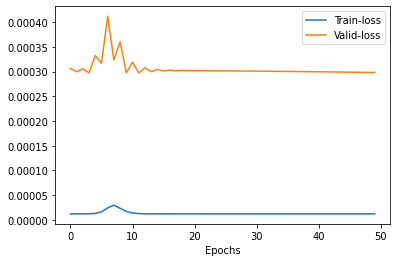

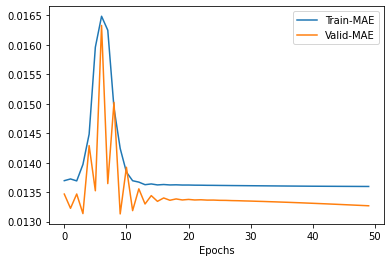

####################

Start training for stock: 1803
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Train metrics: {'mse': 0.00034008585498668253, 'mae': 0.01355157233774662}
Validation metrics: {'mse': 0.0003000546130351722, 'mae': 0.013003976084291935}
Average train loss: 1.2733862968161702e-05 | Average val loss: 0.0003000546130351722
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.00033736680052243173, 'mae': 0.013511975295841694}
Validation metrics: {'mse': 0.000301145832054317, 'mae': 0.01314345933496952}
Average train loss: 1.2999994214624167e-05 | Average val loss: 0.000301145832054317
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.0003384752490092069, 'mae': 0.013542348518967628}
Validation metrics: {'mse': 0.000296229321975261, 'mae': 0.012957394123077393}
Average train loss: 1.273706293432042e-05 | Average val loss: 0.000296229321975261
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.0003380978596396744, 'mae': 0.01350632

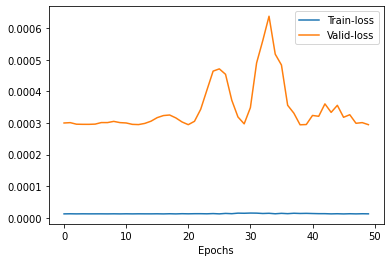

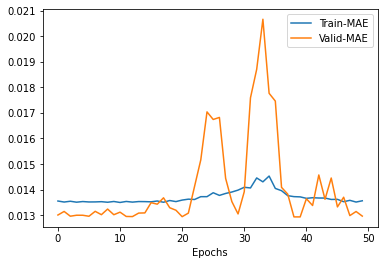

####################

Start training for stock: 1805
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Train metrics: {'mse': 0.000402032514102757, 'mae': 0.014926506206393242}
Validation metrics: {'mse': 0.0001846752129495144, 'mae': 0.009911889210343361}
Average train loss: 1.3476202730089426e-05 | Average val loss: 0.00018467522750142962
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.0004035104066133499, 'mae': 0.014934156090021133}
Validation metrics: {'mse': 0.00018576017464511096, 'mae': 0.009971813298761845}
Average train loss: 1.3669571490027011e-05 | Average val loss: 0.00018576017464511096
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.00040077802259474993, 'mae': 0.014927046373486519}
Validation metrics: {'mse': 0.0001836573501350358, 'mae': 0.009855993092060089}
Average train loss: 1.3839086750522257e-05 | Average val loss: 0.0001836573501350358
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.0004041043866891414, 'mae': 0.

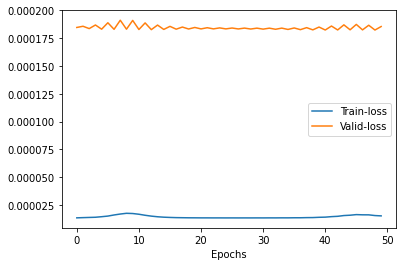

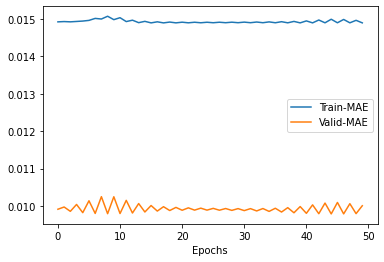

####################

Start training for stock: 1808
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Train metrics: {'mse': 0.000424767640652135, 'mae': 0.014023857191205025}
Validation metrics: {'mse': 0.0002762051299214363, 'mae': 0.012569580227136612}
Average train loss: 1.1357502080500126e-05 | Average val loss: 0.0002762051299214363
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.00041165112634189427, 'mae': 0.013819288462400436}
Validation metrics: {'mse': 0.00025999793433584273, 'mae': 0.01190522313117981}
Average train loss: 1.1277736484771595e-05 | Average val loss: 0.0002599979634396732
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.0004322394379414618, 'mae': 0.014554128982126713}
Validation metrics: {'mse': 0.0003419175336603075, 'mae': 0.01430248562246561}
Average train loss: 1.2944487389177084e-05 | Average val loss: 0.0003419175336603075
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.0004383537161629647, 'mae': 0.0145

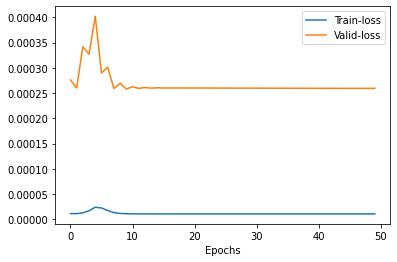

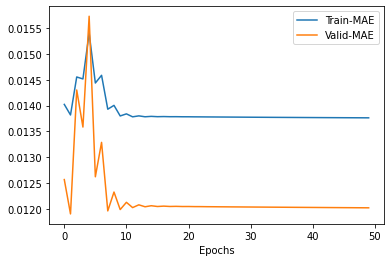

####################

Start training for stock: 1810
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Train metrics: {'mse': 0.0005396699416451156, 'mae': 0.017527109012007713}
Validation metrics: {'mse': 0.0004632290219888091, 'mae': 0.016444453969597816}
Average train loss: 1.4028092846274375e-05 | Average val loss: 0.0004632290219888091
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.0005407990538515151, 'mae': 0.017509955912828445}
Validation metrics: {'mse': 0.0004546241834759712, 'mae': 0.01631542295217514}
Average train loss: 1.430375559721142e-05 | Average val loss: 0.0004546242125798017
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.0005381113151088357, 'mae': 0.017491625621914864}
Validation metrics: {'mse': 0.00047155559877865016, 'mae': 0.01663011498749256}
Average train loss: 1.4566951722372324e-05 | Average val loss: 0.00047155559877865016
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.0005416581407189369, 'mae': 0.0175

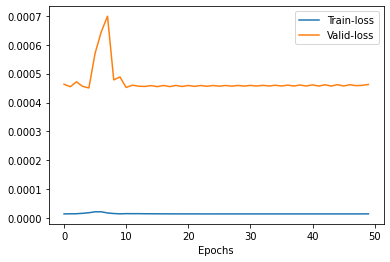

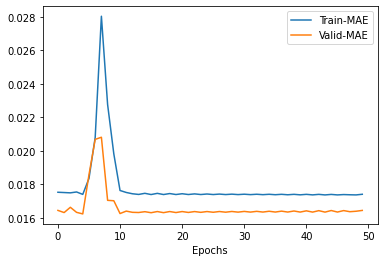

####################

Start training for stock: 1811
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Train metrics: {'mse': 0.0004810733662452549, 'mae': 0.014958357438445091}
Validation metrics: {'mse': 0.00031754665542393923, 'mae': 0.01114489883184433}
Average train loss: 1.8712776363827287e-05 | Average val loss: 0.00031754665542393923
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.00047463623923249543, 'mae': 0.014973550103604794}
Validation metrics: {'mse': 0.00031674333149567246, 'mae': 0.01119120791554451}
Average train loss: 1.8293349421583115e-05 | Average val loss: 0.00031674333149567246
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.0004788462829310447, 'mae': 0.014954124577343464}
Validation metrics: {'mse': 0.0003167746472172439, 'mae': 0.011155450716614723}
Average train loss: 1.8523556354921312e-05 | Average val loss: 0.0003167746472172439
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.00047377723967656493, 'mae': 0

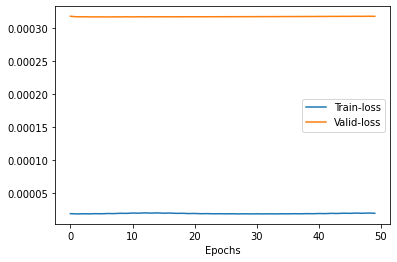

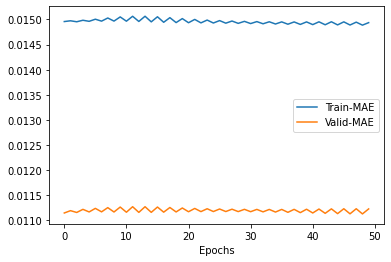

####################

Start training for stock: 1812
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Train metrics: {'mse': 0.00038714014226570725, 'mae': 0.014298202469944954}
Validation metrics: {'mse': 0.00027470383793115616, 'mae': 0.012971469201147556}
Average train loss: 1.3746389595326036e-05 | Average val loss: 0.00027470383793115616
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.0003831096109934151, 'mae': 0.014239036478102207}
Validation metrics: {'mse': 0.00026993348728865385, 'mae': 0.012892017140984535}
Average train loss: 1.329782244283706e-05 | Average val loss: 0.00026993348728865385
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.0003849272907245904, 'mae': 0.014264256693422794}
Validation metrics: {'mse': 0.0002759337949100882, 'mae': 0.013022040016949177}
Average train loss: 1.3279316772241145e-05 | Average val loss: 0.0002759337949100882
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.0003834905510302633, 'mae': 0

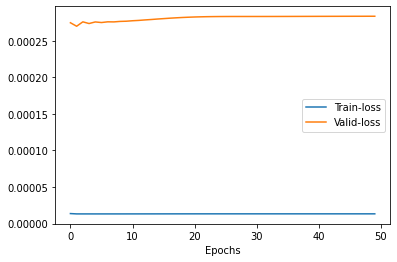

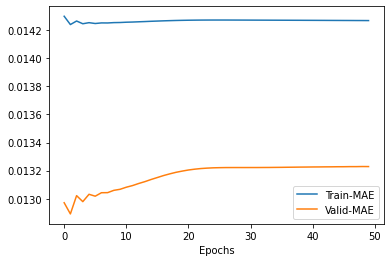

####################

Start training for stock: 1813
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Train metrics: {'mse': 0.00041483438690193, 'mae': 0.01452719047665596}
Validation metrics: {'mse': 0.0001888980041258037, 'mae': 0.0104668028652668}
Average train loss: 1.2468973000068218e-05 | Average val loss: 0.0001888980041258037
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.0004127710126340389, 'mae': 0.014490887522697449}
Validation metrics: {'mse': 0.0001742141757858917, 'mae': 0.009924245066940784}
Average train loss: 1.258507982129231e-05 | Average val loss: 0.0001742141757858917
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.0004111740563530475, 'mae': 0.01446489803493023}
Validation metrics: {'mse': 0.00016824404883664101, 'mae': 0.009711598046123981}
Average train loss: 1.2365300790406764e-05 | Average val loss: 0.00016824404883664101
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.0004092759336344898, 'mae': 0.01448597

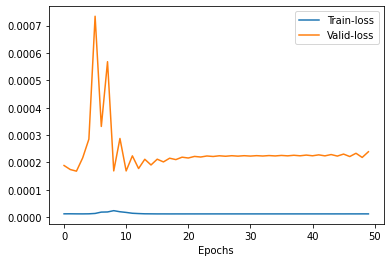

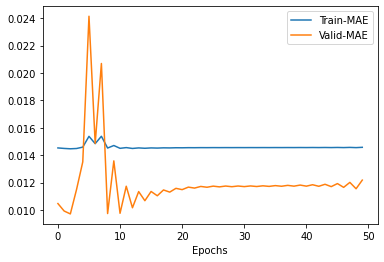

####################

Start training for stock: 1814
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Train metrics: {'mse': 0.0003175538731738925, 'mae': 0.012840366922318935}
Validation metrics: {'mse': 0.0004500932991504669, 'mae': 0.014704324305057526}
Average train loss: 1.7899669182952492e-05 | Average val loss: 0.0004500932991504669
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.0003525644715409726, 'mae': 0.013758573681116104}
Validation metrics: {'mse': 0.0004726970801129937, 'mae': 0.014911971054971218}
Average train loss: 3.0479315319098534e-05 | Average val loss: 0.0004726970801129937
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.0005131091456860304, 'mae': 0.017441174015402794}
Validation metrics: {'mse': 0.0005480988183990121, 'mae': 0.016678370535373688}
Average train loss: 4.8413328477181496e-05 | Average val loss: 0.0005480988183990121
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.0005128124030306935, 'mae': 0.017

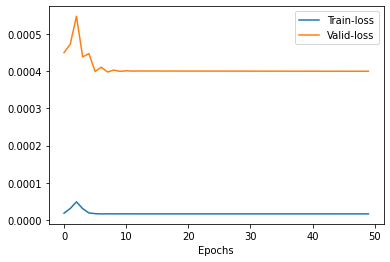

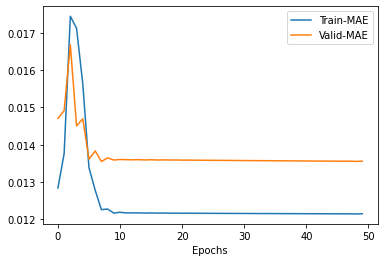

####################

Start training for stock: 1815
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Train metrics: {'mse': 0.000327256420860067, 'mae': 0.01276375912129879}
Validation metrics: {'mse': 0.00013418500020634383, 'mae': 0.008689802139997482}
Average train loss: 1.182058040285483e-05 | Average val loss: 0.00013418500020634383
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.00032945870771072805, 'mae': 0.012803776189684868}
Validation metrics: {'mse': 0.00013190614117775112, 'mae': 0.008550927974283695}
Average train loss: 1.1901765537913888e-05 | Average val loss: 0.00013190615572966635
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.0003206940309610218, 'mae': 0.012614970095455647}
Validation metrics: {'mse': 0.00014499467215500772, 'mae': 0.00921591930091381}
Average train loss: 1.1927221203222871e-05 | Average val loss: 0.00014499467215500772
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.0003352854400873184, 'mae': 0.

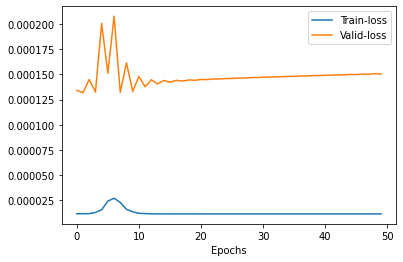

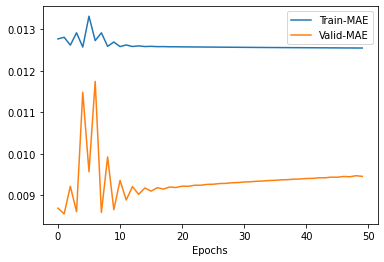

####################

Start training for stock: 1820
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Train metrics: {'mse': 0.0003502758627291769, 'mae': 0.013636888936161995}
Validation metrics: {'mse': 0.00026930164312943816, 'mae': 0.012417382560670376}
Average train loss: 1.2802553828805686e-05 | Average val loss: 0.00026930164312943816
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.0003438743588048965, 'mae': 0.013482458889484406}
Validation metrics: {'mse': 0.0002758319315034896, 'mae': 0.012614523060619831}
Average train loss: 1.2662434892263264e-05 | Average val loss: 0.00027583196060732007
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.000343373540090397, 'mae': 0.013461082242429256}
Validation metrics: {'mse': 0.0002674153074622154, 'mae': 0.012351923622190952}
Average train loss: 1.2715463526546955e-05 | Average val loss: 0.0002674153074622154
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.00034146668622270226, 'mae': 0.

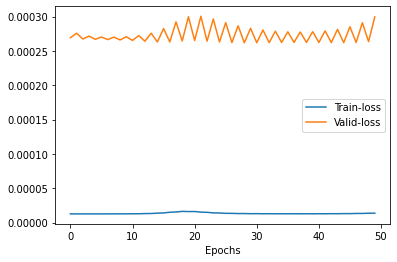

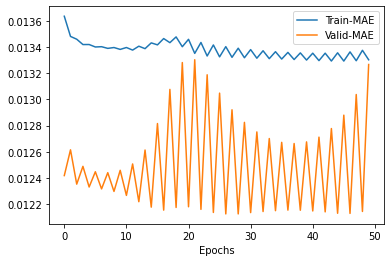

####################

Start training for stock: 1821
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Train metrics: {'mse': 0.0003877259441651404, 'mae': 0.014365993440151215}
Validation metrics: {'mse': 0.0002651405811775476, 'mae': 0.011650354601442814}
Average train loss: 1.3287656474858523e-05 | Average val loss: 0.0002651405811775476
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.00040080444887280464, 'mae': 0.01469862274825573}
Validation metrics: {'mse': 0.00026671119849197567, 'mae': 0.011497157625854015}
Average train loss: 1.3527294504456222e-05 | Average val loss: 0.00026671119849197567
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.0003869690699502826, 'mae': 0.014367461204528809}
Validation metrics: {'mse': 0.0002664398343767971, 'mae': 0.011699548922479153}
Average train loss: 1.3509993732441216e-05 | Average val loss: 0.0002664398343767971
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.00039454366196878254, 'mae': 0.

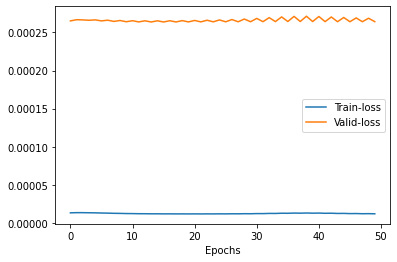

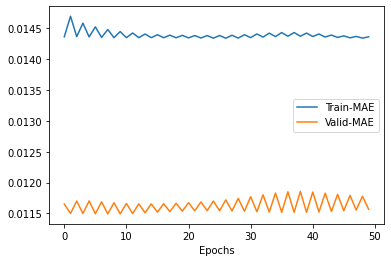

####################

Start training for stock: 1822
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Train metrics: {'mse': 0.0003755859797820449, 'mae': 0.014238737523555756}
Validation metrics: {'mse': 0.0006662032101303339, 'mae': 0.023244956508278847}
Average train loss: 1.8369407916907222e-05 | Average val loss: 0.0006662032101303339
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.000425513309892267, 'mae': 0.01551058329641819}
Validation metrics: {'mse': 0.0013759125722572207, 'mae': 0.03497110679745674}
Average train loss: 2.088602486765012e-05 | Average val loss: 0.0013759126886725426
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.0003830043424386531, 'mae': 0.01441870629787445}
Validation metrics: {'mse': 0.0004366071952972561, 'mae': 0.018035318702459335}
Average train loss: 2.4586878134869038e-05 | Average val loss: 0.00043660722440108657
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.0003693960316013545, 'mae': 0.0140253

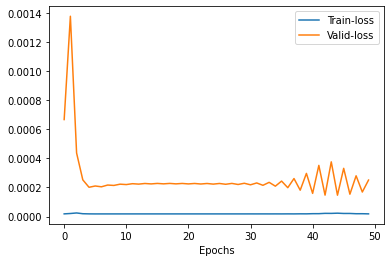

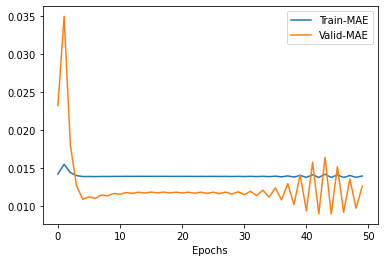

####################

Start training for stock: 1833
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Train metrics: {'mse': 0.0003410924691706896, 'mae': 0.013071245513856411}
Validation metrics: {'mse': 0.000271972909104079, 'mae': 0.011877262033522129}
Average train loss: 1.2701615924015642e-05 | Average val loss: 0.000271972909104079
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.0003358626854605973, 'mae': 0.012925299815833569}
Validation metrics: {'mse': 0.0002705512451939285, 'mae': 0.011842777021229267}
Average train loss: 1.2160337064415216e-05 | Average val loss: 0.0002705512451939285
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.0003384036535862833, 'mae': 0.013005241751670837}
Validation metrics: {'mse': 0.0002721342898439616, 'mae': 0.011883542872965336}
Average train loss: 1.2186748790554702e-05 | Average val loss: 0.0002721342898439616
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.00033617878216318786, 'mae': 0.0129

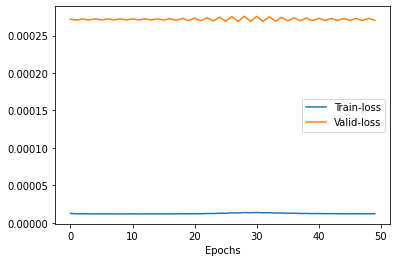

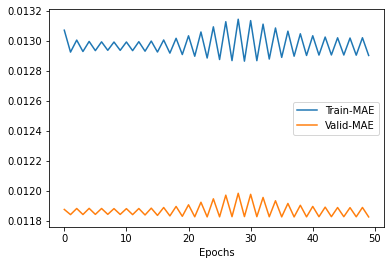

####################

Start training for stock: 1835
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Train metrics: {'mse': 0.00025685736909508705, 'mae': 0.012242618948221207}
Validation metrics: {'mse': 0.00022191669268067926, 'mae': 0.01140530128031969}
Average train loss: 1.2839818373322487e-05 | Average val loss: 0.00022191669268067926
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.0002491363848093897, 'mae': 0.011771204881370068}
Validation metrics: {'mse': 0.00020947761368006468, 'mae': 0.010934012942016125}
Average train loss: 1.313336251769215e-05 | Average val loss: 0.0002094776282319799
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.0002626007189974189, 'mae': 0.012457913719117641}
Validation metrics: {'mse': 0.0002335135213797912, 'mae': 0.011810782365500927}
Average train loss: 1.32118453620933e-05 | Average val loss: 0.0002335135213797912
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.0002597806160338223, 'mae': 0.012

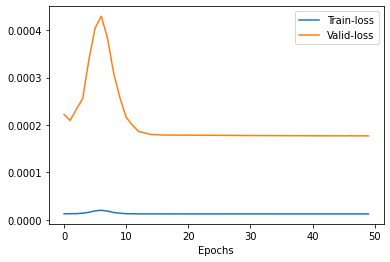

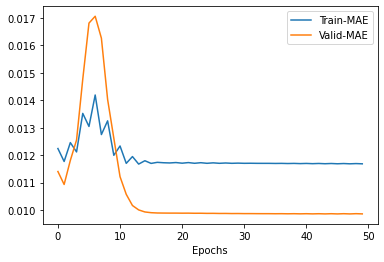

####################

Start training for stock: 1852
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Train metrics: {'mse': 0.0006869081407785416, 'mae': 0.015901105478405952}
Validation metrics: {'mse': 0.0003303839184809476, 'mae': 0.013355463743209839}
Average train loss: 2.3199601855594665e-05 | Average val loss: 0.00033038394758477807
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.000689167354721576, 'mae': 0.01608124189078808}
Validation metrics: {'mse': 0.0003458202409092337, 'mae': 0.013808398507535458}
Average train loss: 2.415974740870297e-05 | Average val loss: 0.0003458202409092337
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.0007101040100678802, 'mae': 0.016585731878876686}
Validation metrics: {'mse': 0.0005888372543267906, 'mae': 0.020256459712982178}
Average train loss: 2.4186728114727885e-05 | Average val loss: 0.0005888372543267906
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.0007281344733200967, 'mae': 0.01714

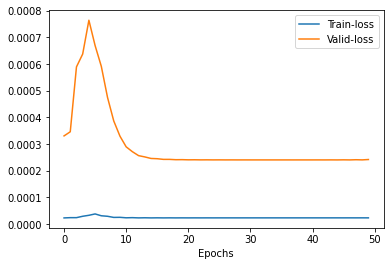

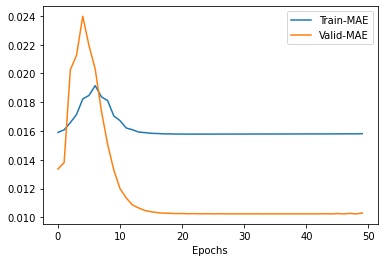

####################

Start training for stock: 1860
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Train metrics: {'mse': 0.0004003766516689211, 'mae': 0.01534972246736288}
Validation metrics: {'mse': 0.00028371193911880255, 'mae': 0.013385448604822159}
Average train loss: 1.5296912170015276e-05 | Average val loss: 0.00028371193911880255
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.0004003929498139769, 'mae': 0.015404259786009789}
Validation metrics: {'mse': 0.00029981255647726357, 'mae': 0.01374133862555027}
Average train loss: 1.5586666995659472e-05 | Average val loss: 0.00029981255647726357
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.0003944226773455739, 'mae': 0.015197175554931164}
Validation metrics: {'mse': 0.0002837531210388988, 'mae': 0.013246051967144012}
Average train loss: 1.5950461965985595e-05 | Average val loss: 0.0002837531210388988
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.00040153649752028286, 'mae': 0.

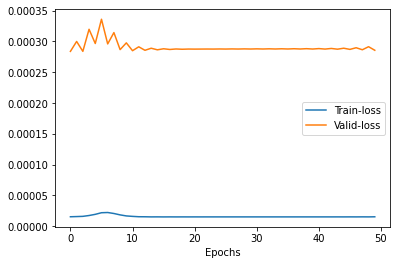

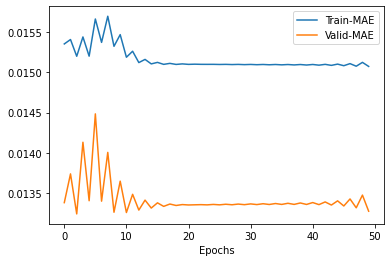

####################

Start training for stock: 1861
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Train metrics: {'mse': 0.00036523331073112786, 'mae': 0.013751653023064137}
Validation metrics: {'mse': 0.00021971392561681569, 'mae': 0.011306775733828545}
Average train loss: 1.8641530186869203e-05 | Average val loss: 0.00021971392561681569
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.00035981120890937746, 'mae': 0.013741954229772091}
Validation metrics: {'mse': 0.00021601401385851204, 'mae': 0.011222234927117825}
Average train loss: 2.1372023911681027e-05 | Average val loss: 0.00021601401385851204
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.00038552601472474635, 'mae': 0.014152723364531994}
Validation metrics: {'mse': 0.00022837449796497822, 'mae': 0.011569504626095295}
Average train loss: 4.010182747151703e-05 | Average val loss: 0.00022837451251689345
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.0003692288009915501, 'mae

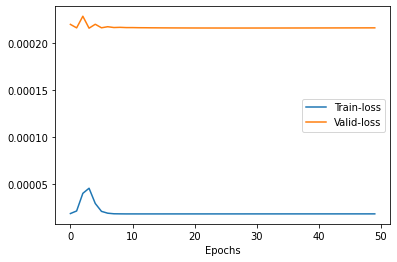

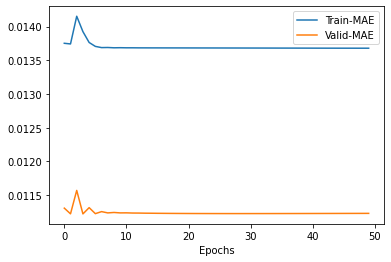

####################

CPU times: total: 1h 20min 52s
Wall time: 1h 20min 58s


In [6]:
%%time
stocks = train_df['SecuritiesCode'].unique()
count = 0
BATCH_SIZE = 512

trainer = Trainer(model, optimizer_name='rmsprop', lr=1.3333e-5)
torch.autograd.set_detect_anomaly(True)

for s in stocks:
    train_loader, val_dataloader = None, None
    if count > 50:
        break
    print(f'Start training for stock: {s}')

    train_dataloader, val_dataloader = dataloader_by_stock(
        train_df, s, batch_size=BATCH_SIZE, continous_cols=CONT_COLS)

    trainer.fit_epochs(
        train_dataloader, 
        val_dataloader, 
        use_cyclic_lr=True, 
        x_cat=True, 
        epochs=50
    )
    print('#' * 20)
    print()
    count += 1
    
    